In [56]:
# Load sentence retrieval result
def main(model_name,
         dataset_name,
        dropout,
        temp
    ):
    import json 
    with open(f"/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/retrieval/results/{model_name}/{dataset_name}-n-query-mt-2-d2d-retrieval{dropout}.jsonl") as f:
        result = [json.loads(i) for i in f.readlines()]
    print(f"{model_name}/{dataset_name}-n-query-mt-2-d2d-retrieval{dropout}.jsonl")
    
    
    # Load csv file for recall, precision, and f1
    import pandas as pd
    path = f"/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/retrieval/results/{model_name}/{dataset_name}-n-query-mt-2.csv"
    print(path)
    df = pd.read_csv(path)
    df = df.drop('Unnamed: 0', axis=1)
    df = df.set_index("corpus-id")
    df.sort_values("recall", ascending=True)
    
    # Get grad norm dict
    n_aug = 16
    selection = ("min", "mean")[1] 
    pth = "/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/gradnorm/"
    
    def load_file(pth):
        with open(pth) as f:
            lines = f.readlines() 
        return lines 
        
    def get_gradnorms(pth):
        lines = load_file(pth)
        gradnorms = []
        for l in lines:
            try: 
                l = l.replace('\'', '"')
                item = json.loads(l)
                gradnorms.append(float(item["grad_norm"]))
            except Exception as e:
                continue
        ids = []
        for l in lines:
            try:
                sid = l.index("doc_id: ") + len("doc_id: ") 
                eid = sid
                ids.append(l[sid:].strip())
            except Exception as e:
                continue
    
        gradnorms_selected = []
        ids_selected = []
        func = lambda x: min(x) if selection == "min" else sum(x) / len(x)
        for i in range(0, len(ids)-1, 16):
            gradnorms_selected.append(func(gradnorms[i:i+n_aug]))
            ids_selected.append(ids[i])
        gradnorm_dict = {cid: gradnorm for cid, gradnorm in zip(ids_selected, gradnorms_selected)}
                
        return gradnorm_dict
    
    print(f"{model_name}/{dataset_name}-result{dropout}-temp-{temp}")
    gradnorm_dict = get_gradnorms(pth + f"{model_name}/{dataset_name}-result{dropout}-temp-{temp}") #-temp-0.02")
    
    # Load result
    scores = []
    recalls = []
    precisions = []
    gradnorms = []
    cids = []
    f1s = []
    for i in result:
        try:
            cid = i["_id"]
            #if df.loc[cid]["f1"] < 0:
            #    continue
            cids.append(cid)
            #if df.loc[cid]["n-query"] < 15:
            #    continue
            #if df.loc[cid]["recall"]) ==0:
            #    continue
            succ = sum(map(lambda x: cid in x, i["retrieval"][:100]))
            count = len(i["retrieval"])
            if count < 3:
                continue
            score = round(succ / count * 100, 2)
            gradnorms.append(gradnorm_dict[cid])
            scores.append(score)
            recalls.append(df.loc[cid]["recall"])
            precisions.append(df.loc[cid]["precision"])
            f1s.append(df.loc[cid]["f1"])
        except Exception as e:
            continue
    print(len(gradnorms))
    
    import pandas as pd
    from collections import defaultdict
    import seaborn as sns
    
    def cal_mean(lst):
        return round(sum(lst) / len(lst), 1)
        
    # x: recall / y: precision / value: gradnorm 
    ymax = max(precisions) + 0.01
    xlim, ylim = 1 + 0.001, ymax 
    xinterval, yinterval = 1 / 4, round((ymax) /4, 2)
    
    print("Xlim:", xlim, "Ylim:", ylim)
    print("Xinterval:", xinterval, "Yinterval:", yinterval)
    
    xs = [round(xinterval * i, 2) for i in range(int(xlim // xinterval))]
    ys = [round(yinterval * i, 2) for i in range(int(ylim // yinterval))][::-1]
    print("Xs:", xs)
    print("Ys:", ys)
    
    dic = defaultdict(dict)
    for xmin in xs:
        xmax = xmin + xinterval
        sub_dic = defaultdict(float)
        for ymin in ys:
            ymax = ymin + yinterval
            grad_lst = []
            for cid, r, p, g in zip(cids, recalls, precisions, gradnorms):
                if xmin <= r and r <= xmax and ymin <=p and p <= ymax:
                    grad_lst.append(g)
            print("Xmin:", xmin, "Ymin:", ymin, "N:", len(grad_lst))
            grad_mean = cal_mean(grad_lst) if len(grad_lst) > 0 else -1
            sub_dic[ymin] = grad_mean
        dic[xmin] = sub_dic
    
    df = pd.DataFrame(dic)
    print(df)
    ax = sns.heatmap(df, xticklabels=xs, yticklabels=ys, annot=True, cmap="Blues")
    ax.set(xlabel="recalls", ylabel="precisions")
    ax

contriever/nfcorpus-n-query-mt-2-d2d-retrieval-0.02.jsonl
/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/retrieval/results/contriever/nfcorpus-n-query-mt-2.csv
contriever/nfcorpus-result-0.02-temp-0.05
1938
Xlim: 1.001 Ylim: 0.61
Xinterval: 0.25 Yinterval: 0.15
Xs: [0.0, 0.25, 0.5, 0.75]
Ys: [0.45, 0.3, 0.15, 0.0]
Xmin: 0.0 Ymin: 0.45 N: 0
Xmin: 0.0 Ymin: 0.3 N: 0
Xmin: 0.0 Ymin: 0.15 N: 4
Xmin: 0.0 Ymin: 0.0 N: 1412
Xmin: 0.25 Ymin: 0.45 N: 2
Xmin: 0.25 Ymin: 0.3 N: 1
Xmin: 0.25 Ymin: 0.15 N: 11
Xmin: 0.25 Ymin: 0.0 N: 542
Xmin: 0.5 Ymin: 0.45 N: 1
Xmin: 0.5 Ymin: 0.3 N: 0
Xmin: 0.5 Ymin: 0.15 N: 9
Xmin: 0.5 Ymin: 0.0 N: 209
Xmin: 0.75 Ymin: 0.45 N: 0
Xmin: 0.75 Ymin: 0.3 N: 0
Xmin: 0.75 Ymin: 0.15 N: 1
Xmin: 0.75 Ymin: 0.0 N: 44
      0.00  0.25  0.50  0.75
0.45  -1.0  16.9  18.7  -1.0
0.30  -1.0  17.5  -1.0  -1.0
0.15  19.1  18.5  16.5   9.0
0.00  17.7  16.7  16.4  15.5


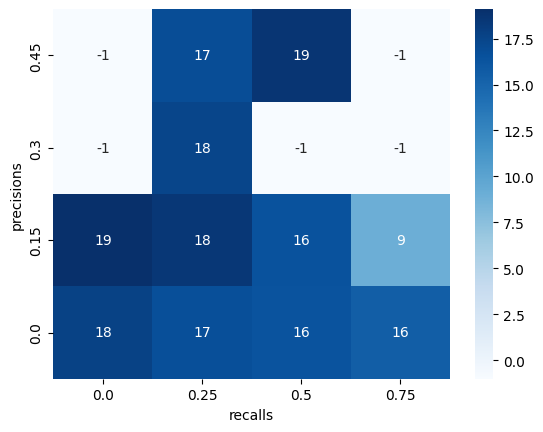

In [60]:
model_name = ["bge-large-en-v1.5", "contriever", "gte-base", "multilingual-e5-large"][1]
dataset_name = ["nfcorpus", "trec-covid"][0]
dropout=["", "-0.02", "-0.05"][1]
temp=[0.01, 0.05, 0.1][1]
main(model_name, dataset_name, dropout, temp)

In [58]:
import matplotlib.pyplot as plt 

# Generate data
x = recalls
y = gradnorms

# Initialize layout
fig, ax = plt.subplots()

# Add scatterplot
ax.scatter(x, y, s=60, alpha=0.03)

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
import numpy as np
b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 100
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.xlabel("recall")
plt.ylabel("gradnorm")
#plt.ylim(15, 40)
plt.title(f"{model_name} / {dataset_name} / {selection} / {round(b, 2)}")
ax.plot(xseq, a + b * xseq, color="k", lw=2.5)

print(b)

NameError: name 'recalls' is not defined

## Heatmap 1

rec: 0.0 - 0.3 / prec:0.25 - 0.3 : 15.2, 3
rec: 0.0 - 0.3 / prec:0.15 - 0.2 : 13.6, 2
rec: 0.0 - 0.3 / prec:0.1 - 0.15 : 12.8, 7
rec: 0.0 - 0.3 / prec:0.05 - 0.1 : 13.9, 50
rec: 0.0 - 0.3 / prec:0.0 - 0.05 : 13.6, 1186
rec: 0.3 - 0.6 / prec:0.15 - 0.2 : 14.5, 2
rec: 0.3 - 0.6 / prec:0.1 - 0.15 : 11.6, 11
rec: 0.3 - 0.6 / prec:0.05 - 0.1 : 13.1, 55
rec: 0.3 - 0.6 / prec:0.0 - 0.05 : 13.3, 442
rec: 0.7 - 1.0 / prec:0.15 - 0.2 : 8.6, 2
rec: 0.7 - 1.0 / prec:0.1 - 0.15 : 12.0, 2
rec: 0.7 - 1.0 / prec:0.05 - 0.1 : 12.8, 18
rec: 0.7 - 1.0 / prec:0.0 - 0.05 : 13.1, 56
rec: 1.0 - 1.3 / prec:0.05 - 0.1 : 13.2, 6
rec: 1.0 - 1.3 / prec:0.0 - 0.05 : 13.4, 17


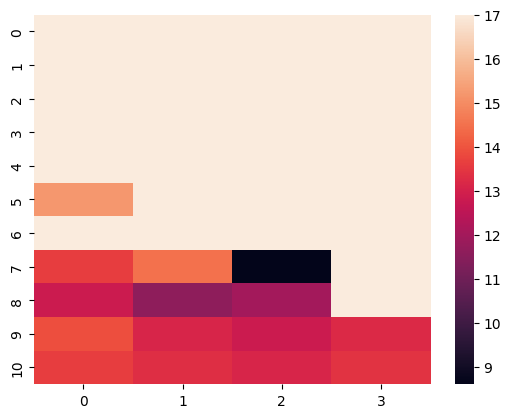

In [613]:
entire_results = []
for i in range(0, 4):
    sub_results = []
    i = round(i/3, 1)
    for j in range(10, -1, -1):
        j = round(j/20, 2)
        lst = []
        for cid, r, p, g in zip(cids, recalls, precisions, gradnorms):
            if i <= r and r < i + 1/3 and j <=p and p < j + 1/20:
                lst.append(g)
        if len(lst) > 1:
            result = round(sum(lst) / len(lst), 1)
            print(f"rec: {i} - {round(i+1/3, 1)} / prec:{j} - {round(j+1/20, 2)} : {round(sum(lst) / len(lst), 1)}, {len(lst)}")
            sub_results.append(result)
        else:
            sub_results.append(17)
    entire_results.append(sub_results)

import numpy as np
result = np.asarray(entire_results)
result = result.transpose()

import seaborn as sns
ax = sns.heatmap(result)


### Load grad norm and plot mean 